In [5]:
# Install required packages (uncomment if not already installed)
# !pip install pdf2image pillow
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt

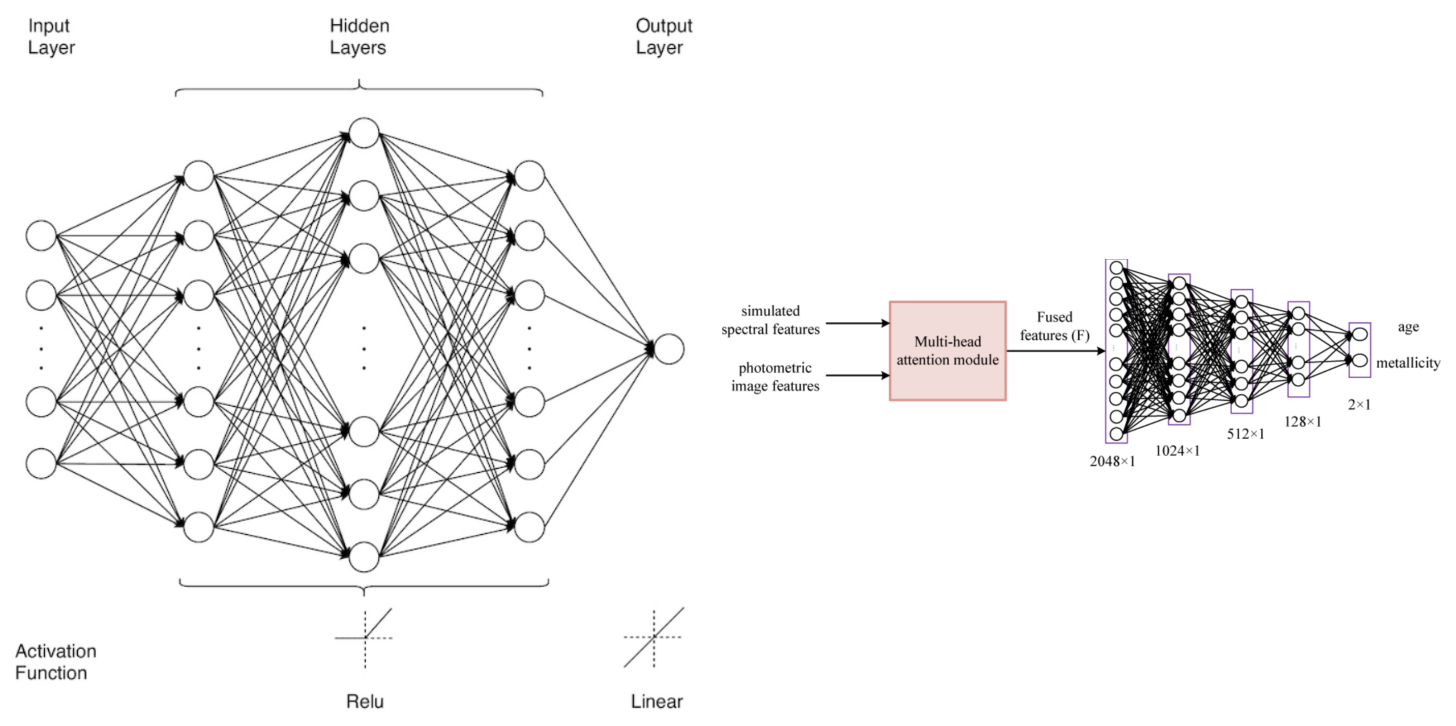

In [16]:
# Convert PDF pages to images with higher DPI for better resolution
pdf1_images = convert_from_path('aa53751-25-fig8.pdf', dpi=500)
pdf2_images = convert_from_path('staa537fig5.pdf', dpi=500)

# Display the first page of each PDF using imshow
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axes[0].imshow(pdf2_images[0])
axes[0].axis('off')
axes[1].imshow(pdf1_images[0])
axes[1].axis('off')
# Save the figure as a PDF file in Proposal/figs
plt.savefig('Proposal/figs/deep_neural_networks.pdf', format='pdf')
plt.show()